#### Regularização em modelos - forma de reduzir sobreajuste
##### No caso de regressão polinomial, um grau polinomial menor é uma estratégia
##### No caso de regressão linear, restringe-se os pesos dos modelos

##### Ridge (Tikhonov): não elimina os pesos, são controlados por um parâmetro. Na prática a função de perda fica
$J(w) = MSE(w) + \alpha \dfrac{1}{2} \sum_{i=1}^n w_i ^2$ e este acréscimo força o ajuste dos dados e a manutenção dos pesos o menor possível. Este termo é adicionado à função de perda apenas no treinamento e avalia-se o modelo pós-treino com as métricas usuais. O intercepto não é afetado pela regularização.

É FUNDAMENTAL escalonar os dados, como o StandardScaler, pois os regularizadores são muitos sensíveis às escalas dos dados. Vamos no exemplo didático abaixo ver a influência da regularização Ridge:

In [1]:
import numpy as np
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42) # ou solver='sag'
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

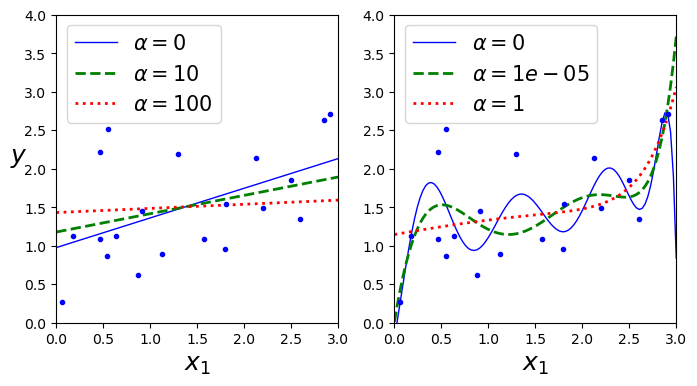

In [5]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

#save_fig("ridge_regression_plot")
plt.show()

##### Se usar um SGD, por exemplo, e em outros modelos também, há um parâmetro PENALTY, ou seja, penalidade. Por exemplo, no SGDRegressor, penalty='l2' significa usar Ridge e 'l1' significa usar Lasso

In [10]:
from sklearn.linear_model import SGDRegressor


sgd_reg = SGDRegressor(penalty='l2', max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

##### Já a Regressão de Lasso (least absolute shrinkage and selection operator regression), adiciona um termo à função de perda para o treinamento, da forma: $J(w) = MSE(w) + \alpha \sum_{i=1}^n |w_i|$. Ela naturalmente faz seleção de features, pois tende a suprimir os pesos de features menos importantes (coloca-os como zero). No exemplo abaixo, para o caso polinomial com grau 10 e valor de $\alpha=1e-7$ parece quadrática, quase linear, pois todos os pesos para features de alto grau são zero

c:\Users\josen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.803e+00, tolerance: 9.295e-04
  model = cd_fast.enet_coordinate_descent(


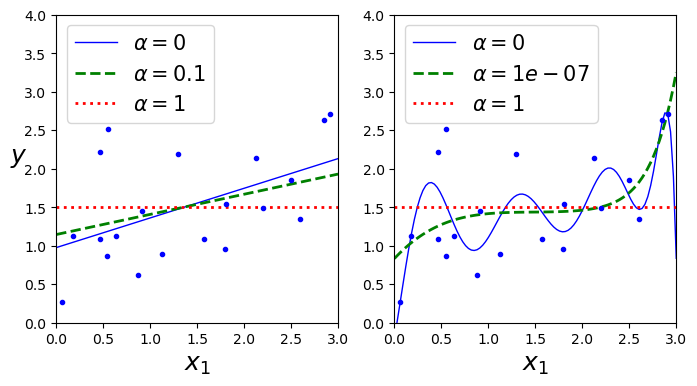

In [11]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

#save_fig("lasso_regression_plot")
plt.show()

In [12]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

##### A regularização Elastic net é um meio-termo, sendo uma combinação da Ridge com a Lasso e pode-se controlar a relação com o parâmetro $r$. Para $r=0$ é Ridge. Para $r=1$ é Lasso. A função de perda de treino é dada por

$J(w) = MSE(w) + r\alpha \sum_{i=1}^n |w_i| + \dfrac{1-r}{2} \alpha \sum_{i=1}^n w_i^2$

É interessante ter um pouco de regularização. Ridge é um bom padrão mas se suspeitar que apenas algumas features são necessárias, usar Lasso ou Elastic Net. Em geral neste caso prefere-se Elastic Net à Lasso, pois a última pode ter problemas quando o número de features é maior que o conjunto de treinamento ou quando tiver muita correlação entre features.

In [13]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

##### Por último temos a PARADA PRECOCE ou ANTECIPADA para algoritmos iterativos, cuja ideia é parar o treinamento assim que o erro de validação atingir o mínimo

In [14]:
# ideia de early stopping, aplicada à SGDRegressor com polinomio de alto grau (90)

from sklearn.model_selection import train_test_split


np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [27]:
from copy import deepcopy

from sklearn.metrics import mean_squared_error

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=0.0001, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

c:\Users\josen\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\josen\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\josen\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\josen\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\josen\anaconda3\lib\site-packages\sklearn\linea

c:\Users\josen\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\josen\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\josen\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\josen\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\josen\anaconda3\lib\site-packages\sklearn\linea

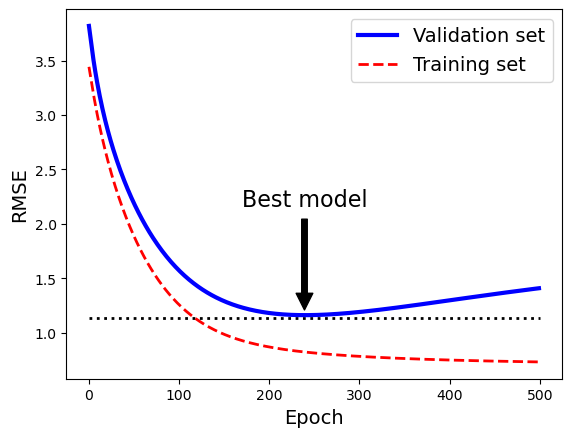

In [31]:
sgd_reg = SGDRegressor(max_iter=1, tol=0.0001, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
#save_fig("early_stopping_plot")
plt.show()